In [2]:
from typing import Tuple
from coherence.custom_types import Batch

import jax
import jax.numpy as jnp

import haiku as hk
import optax

from coherence.data import get_data, decimate, normalize
from coherence.train import network_and_loss, do_training, update_params, net_accuracy
from coherence.models.mlp import lenet_fn

from coherence.pruning import masked_update, imp, global_threshold_prune

from coherence.coherence import ptwise, get_coherence, subnetwork_coherence

from functools import partial

In [5]:
# load mnist data
train, train_eval, test_eval = get_data("mnist",batch_size=100,format_fun=normalize)

# cnn, loss, params
net, xent_loss = network_and_loss(lenet_fn)

key = jax.random.PRNGKey(42)
params = net.init(key, next(train)["image"])

# optimization of network
opt = optax.adam(1e-3)
opt_state = opt.init(params)
accuracy_fn = net_accuracy(net)

cs_in = []
cs_out = []

def calc_coherence(loss_fn,mask):

    # @jax.jit
    def helper(
      params: hk.Params,
      batch: Batch,
    ) -> Tuple[hk.Params, optax.OptState]:

        ptwise_fn = ptwise(loss_fn)
        pt_grads = ptwise_fn(params, batch)

        c = get_coherence(pt_grads)

        c_in, c_out= subnetwork_coherence(c, mask)
        cs_in.append(c_in)
        cs_out.append(c_out)

    return helper
    
def train_fn_mask(mask, key):

    # params = net.init(key, next(train)["image"])
    update_fn = masked_update(opt,xent_loss,mask)

    # train
    final_params = do_training(update_fn, accuracy_fn,params, opt_state, train, train_eval, test_eval,epochs=1001)

    return final_params

def train_fn_trace(mask):

    update_fn = update_params(opt,xent_loss)
    aux_fn = calc_coherence(xent_loss,mask)
    final_params = do_training(
                    update_fn, accuracy_fn, 
                    params, opt_state, 
                    train, train_eval, test_eval, 
                    epochs=1001, 
                    aux_fn=aux_fn,
                    aux_epoch=100,
                    )

    return final_params


masks, branches = imp(key,train_fn_mask,partial(threshold_prune,fraction=0.95),params,num_reps=2)

train_fn_trace(masks[-1])

print("cs_in: ", cs_in)
print("cs_out: ", cs_out)

2022-07-19 20:56:22.024271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 20:56:22.024327: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


[Step 0] Train / Test accuracy: 0.130 / 0.110.
[Step 1000] Train / Test accuracy: 0.970 / 0.980.
266610
[Step 0] Train / Test accuracy: 0.150 / 0.080.
[Step 1000] Train / Test accuracy: 0.970 / 0.970.
13329
[Step 0] Train / Test accuracy: 0.160 / 0.150.
[Step 1000] Train / Test accuracy: 0.960 / 0.960.
cs_in:  [DeviceArray(0.00139763, dtype=float32), DeviceArray(0.00241729, dtype=float32), DeviceArray(0.00210144, dtype=float32), DeviceArray(0.00265211, dtype=float32), DeviceArray(0.00251635, dtype=float32), DeviceArray(0.00286983, dtype=float32), DeviceArray(0.00280728, dtype=float32), DeviceArray(0.00278373, dtype=float32), DeviceArray(0.00247638, dtype=float32), DeviceArray(0.00337641, dtype=float32), DeviceArray(0.00336724, dtype=float32)]
cs_out:  [DeviceArray(0.00055716, dtype=float32), DeviceArray(0.00062829, dtype=float32), DeviceArray(0.00064341, dtype=float32), DeviceArray(0.00073075, dtype=float32), DeviceArray(0.00074298, dtype=float32), DeviceArray(0.00083265, dtype=float32

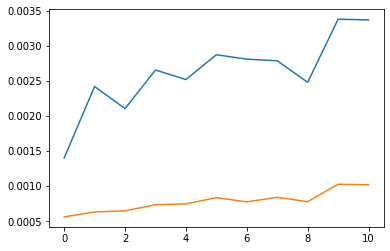

In [6]:
import matplotlib.pyplot as plt
plt.plot(cs_in)
plt.plot(cs_out)